# Project description

**Optimal algorithm for price prediction**

Rusty Bargain, a used car sales service, is developing an app to attract new customers. In that app, one can quickly find out the market value of his/her car. We have access to historical data: technical specifications, trim versions, and prices. Now, we need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the time required for training

Based on above, we will consider different algorithms and tune their hyperparameters to find out optimal model, with highest accuracy with quick prediction.

**The following steps will be carried out in this project:**
- 1. data loading and checking;
- 2. EDA
- 3. Training different models
- 4. Benchmarking: quality and speed


**Data description**

*Features*:

- `DateCrawled` — date profile was downloaded from the database
- `VehicleType` — vehicle body type
- `RegistrationYear` — vehicle registration year
- `Gearbox` — gearbox type
- `Power` — power (hp)
- `Model` — vehicle model
- `Mileage` — mileage (measured in km due to dataset's regional specifics)
- `RegistrationMonth` — vehicle registration month
- `FuelType` — fuel type
- `Brand` — vehicle brand
- `NotRepaired` — vehicle repaired or not
- `DateCreated` — date of profile creation
- `NumberOfPictures` — number of vehicle pictures
- `PostalCode` — postal code of profile owner (user)
- `LastSeen` — date of the last activity of the user

*Target*

- `Price` — price (Euro)

# Data loading and preparation

## Load&look at the data

In [1]:
# required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
import warnings

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb

warnings.filterwarnings('ignore')
#pio.renderers["svg"]
pio.renderers.default = "svg"
pyo.init_notebook_mode()

In [2]:
%%time

# load the data
try:
    # open dataset and parse dates in date-based columns
    dataset = pd.read_csv('datasets/car_data.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'], low_memory=False)
except:
    print('Something went wrong!')

Wall time: 1min 9s


In [3]:
# Date parsing takes too long so let's create a dataset copy
# in order not to parse it every time when we want to make some changes 
data = dataset.copy()

In [4]:
data.head()

DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0 2016-03-24 11:52:00    480         NaN              1993  manual      0   
1 2016-03-24 10:58:00  18300       coupe              2011  manual    190   
2 2016-03-14 12:52:00   9800         suv              2004    auto    163   
3 2016-03-17 16:54:00   1500       small              2001  manual     75   
4 2016-03-31 17:25:00   3600       small              2008  manual     69   

   Model  Mileage  RegistrationMonth  FuelType       Brand NotRepaired  \
0   golf   150000                  0    petrol  volkswagen         NaN   
1    NaN   125000                  5  gasoline        audi         yes   
2  grand   125000                  8  gasoline        jeep         NaN   
3   golf   150000                  6    petrol  volkswagen          no   
4  fabia    90000                  7  gasoline       skoda          no   

  DateCreated  NumberOfPictures  PostalCode            LastSeen  
0  2016-03-24                 0       70435 2016-07-04 03:16:00  
1  2016-03-24                 0       66954 2016-07-04 01:46:00  
2  2016-03-14                 0       90480 2016-05-04 12:47:00  
3  2016-03-17                 0       91074 2016-03-17 17:40:00  
4  2016-03-31                 0       60437 2016-06-04 10:17:00

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Mileage            354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

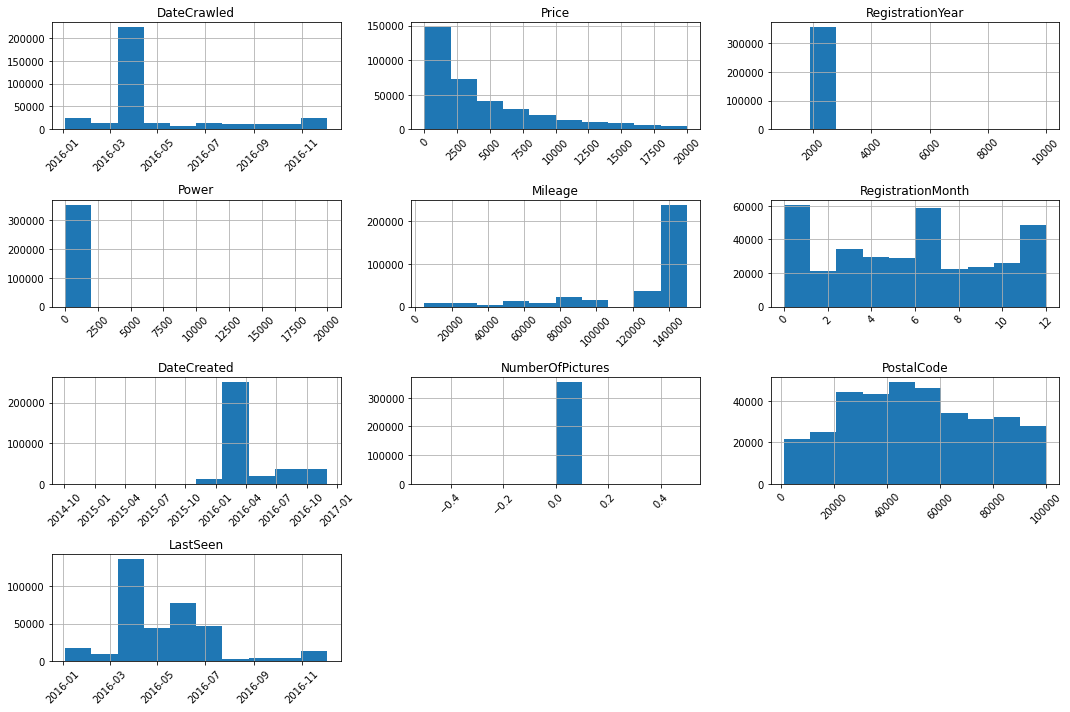

In [6]:
data.hist(figsize=(15, 10), xrot=45)
plt.tight_layout()
plt.show()

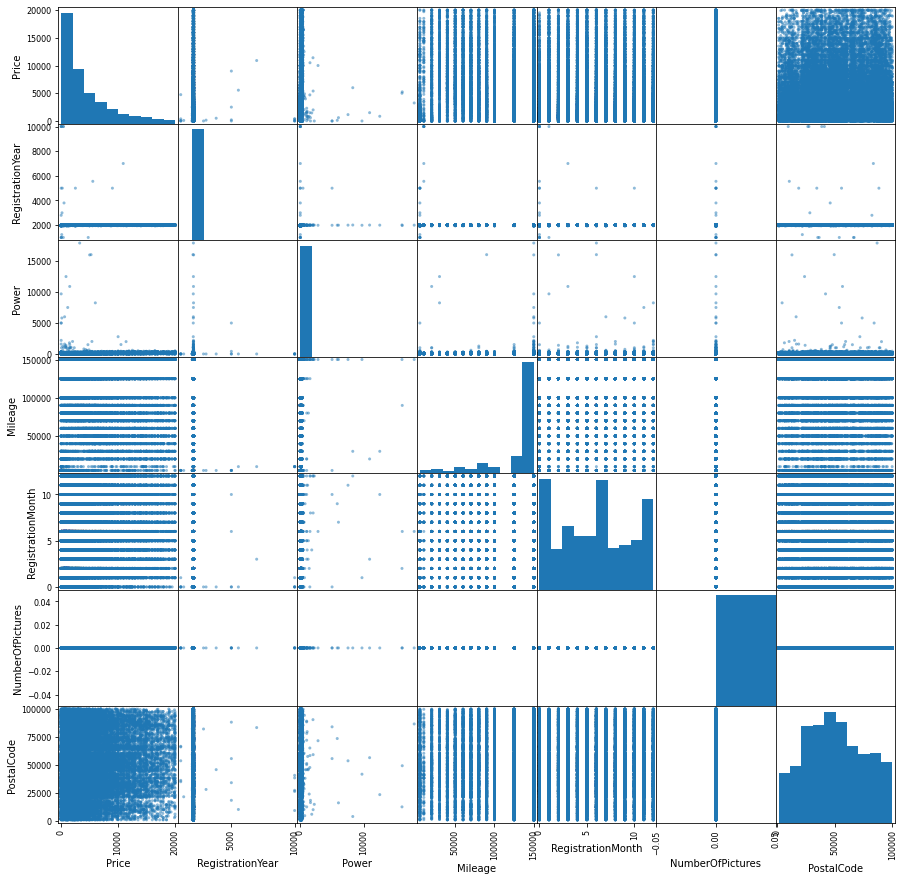

In [7]:
pd.plotting.scatter_matrix(data.sample(frac=0.1), figsize=(15, 15));

In [8]:
# Looking for multucollinearity 
data.corr().round(2).style.background_gradient()

**Intermediate conclusion:**
- no significant positive correlation between the columns hasn't been found
- negative correlation between mileage and price has been detected which is logical
- columns' names should be corrected
- data need to be checked for sanity
- column `NumberOfPictures` has no values, thus should be deleted
- date-based columns have been parsed during loading the dataset

## Fixing data problems

### Rename all columns

In [9]:
# change column names to pythonic way
data.columns = ['date_crawled', 'price', 'vehicle_type', 'reg_year', 'gear_box', 'power', 'model', 'mileage',
                'reg_month', 'fuel_type', 'brand', 'not_repaired', 'date_created', 'n_pictures',
                'postal_code', 'last_seen']
data.head()

date_crawled  price vehicle_type  reg_year gear_box  power  model  \
0 2016-03-24 11:52:00    480          NaN      1993   manual      0   golf   
1 2016-03-24 10:58:00  18300        coupe      2011   manual    190    NaN   
2 2016-03-14 12:52:00   9800          suv      2004     auto    163  grand   
3 2016-03-17 16:54:00   1500        small      2001   manual     75   golf   
4 2016-03-31 17:25:00   3600        small      2008   manual     69  fabia   

   mileage  reg_month fuel_type       brand not_repaired date_created  \
0   150000          0    petrol  volkswagen          NaN   2016-03-24   
1   125000          5  gasoline        audi          yes   2016-03-24   
2   125000          8  gasoline        jeep          NaN   2016-03-14   
3   150000          6    petrol  volkswagen           no   2016-03-17   
4    90000          7  gasoline       skoda           no   2016-03-31   

   n_pictures  postal_code           last_seen  
0           0        70435 2016-07-04 03:16:00  
1           0        66954 2016-07-04 01:46:00  
2           0        90480 2016-05-04 12:47:00  
3           0        91074 2016-03-17 17:40:00  
4           0        60437 2016-06-04 10:17:00

### Delete the `n_pictures` column

In [10]:
# look on values in the `n_pictures` column
display(data.n_pictures.value_counts())

#it is empy - delete it
data = data.drop('n_pictures', axis=1)

0    354369
Name: n_pictures, dtype: int64

### Values correction (reg_year, power, price)

In [11]:
# remove values with inappropriate registration years
condition = (data.reg_year > data.date_created.dt.year) | (data.reg_year < 1915)
data = data[~condition]

In [12]:
#calculate the outliers in 'power' columns
power_outlier = data['power'].quantile(0.75) + (data['power'].quantile(0.75) - data['power'].quantile(0.25))*1.5
print('power_outlier value = ', power_outlier)

# remove all outlier `power` values 
data = data[data['power'] < power_outlier]

power_outlier value =  254.0


In [13]:
# we can see, that there are a lot of zero-prices
display(data[['price']].value_counts().to_frame().head())

# let's replace these values with np.nan
#data.price = data.price.apply(lambda x: np.nan if x == 0 else x)

# remove all data with zero prices
data = data[data.price > 0]

0
price      
0      9786
500    5452
1500   5055
1000   4346
1200   4316

### Create a vehicle age column

In [14]:
data['age'] = data['date_created'].dt.year - data['reg_year']

# some age values appear to be negative - let's fix it
data.age = data.age.apply(lambda x: 0 if x < 0 else x)
data.head()

date_crawled  price vehicle_type  reg_year gear_box  power  model  \
0 2016-03-24 11:52:00    480          NaN      1993   manual      0   golf   
1 2016-03-24 10:58:00  18300        coupe      2011   manual    190    NaN   
2 2016-03-14 12:52:00   9800          suv      2004     auto    163  grand   
3 2016-03-17 16:54:00   1500        small      2001   manual     75   golf   
4 2016-03-31 17:25:00   3600        small      2008   manual     69  fabia   

   mileage  reg_month fuel_type       brand not_repaired date_created  \
0   150000          0    petrol  volkswagen          NaN   2016-03-24   
1   125000          5  gasoline        audi          yes   2016-03-24   
2   125000          8  gasoline        jeep          NaN   2016-03-14   
3   150000          6    petrol  volkswagen           no   2016-03-17   
4    90000          7  gasoline       skoda           no   2016-03-31   

   postal_code           last_seen  age  
0        70435 2016-07-04 03:16:00   23  
1        66954 2016-07-04 01:46:00    5  
2        90480 2016-05-04 12:47:00   12  
3        91074 2016-03-17 17:40:00   15  
4        60437 2016-06-04 10:17:00    8

### Correcting values in the `fuel_type` column

In [15]:
data.fuel_type.value_counts()

petrol      199546
gasoline     93865
lpg           4528
cng            531
hybrid         217
other          160
electric        85
Name: fuel_type, dtype: int64

> We can see that top-2 values are `petrol` and `gasoline` which are the same substance. Let's replace `gasoline` with `petrol` in the column.

In [16]:
data.fuel_type.replace('gasoline', 'petrol', inplace=True)

### Duplicates

In [17]:
# duplicates in the dataset
data.duplicated().sum()

254

In [18]:
# let's look at them closer
data[data.duplicated(keep=False)].sort_values(['date_crawled', 'price', 'vehicle_type']).head(6)

date_crawled  price vehicle_type  reg_year gear_box  power  \
87112  2016-01-04 05:02:00   6199        coupe      1999   manual    193   
90786  2016-01-04 05:02:00   6199        coupe      1999   manual    193   
45825  2016-01-04 10:38:00   3499        small      2005   manual     86   
142496 2016-01-04 10:38:00   3499        small      2005   manual     86   
12578  2016-01-04 12:57:00   1499        wagon      1995   manual    150   
112470 2016-01-04 12:57:00   1499        wagon      1995   manual    150   

       model  mileage  reg_month fuel_type    brand not_repaired date_created  \
87112    3er   150000          5    petrol      bmw           no   2016-01-04   
90786    3er   150000          5    petrol      bmw           no   2016-01-04   
45825   getz    50000          5    petrol  hyundai           no   2016-01-04   
142496  getz    50000          5    petrol  hyundai           no   2016-01-04   
12578    5er   150000          6    petrol      bmw           no   2016-01-04   
112470   5er   150000          6    petrol      bmw           no   2016-01-04   

        postal_code           last_seen  age  
87112         99974 2016-07-04 06:15:00   17  
90786         99974 2016-07-04 06:15:00   17  
45825         47800 2016-07-04 06:46:00   11  
142496        47800 2016-07-04 06:46:00   11  
12578         25821 2016-07-04 09:44:00   21  
112470        25821 2016-07-04 09:44:00   21

In [19]:
# drop the duplicates
data.drop_duplicates(keep='first', inplace=True)

### Values correction from np.nan to 'unknown'

In [20]:
cat_columns = ['vehicle_type', 'gear_box', 'model', 'fuel_type', 'brand', 'not_repaired']
data[cat_columns] = data[cat_columns].fillna('unknown')

In [21]:
data.head()

date_crawled  price vehicle_type  reg_year gear_box  power    model  \
0 2016-03-24 11:52:00    480      unknown      1993   manual      0     golf   
1 2016-03-24 10:58:00  18300        coupe      2011   manual    190  unknown   
2 2016-03-14 12:52:00   9800          suv      2004     auto    163    grand   
3 2016-03-17 16:54:00   1500        small      2001   manual     75     golf   
4 2016-03-31 17:25:00   3600        small      2008   manual     69    fabia   

   mileage  reg_month fuel_type       brand not_repaired date_created  \
0   150000          0    petrol  volkswagen      unknown   2016-03-24   
1   125000          5    petrol        audi          yes   2016-03-24   
2   125000          8    petrol        jeep      unknown   2016-03-14   
3   150000          6    petrol  volkswagen           no   2016-03-17   
4    90000          7    petrol       skoda           no   2016-03-31   

   postal_code           last_seen  age  
0        70435 2016-07-04 03:16:00   23  
1        66954 2016-07-04 01:46:00    5  
2        90480 2016-05-04 12:47:00   12  
3        91074 2016-03-17 17:40:00   15  
4        60437 2016-06-04 10:17:00    8

### Missing values

In [22]:
# missed values 
data.isna().sum()

date_crawled    0
price           0
vehicle_type    0
reg_year        0
gear_box        0
power           0
model           0
mileage         0
reg_month       0
fuel_type       0
brand           0
not_repaired    0
date_created    0
postal_code     0
last_seen       0
age             0
dtype: int64

### Change the dtype of some columns

In [23]:
# a function that takes dataset, a numbet of columns for dtype changing and an according dtype
def dtype_switch(dataset, columns_change, dtype):
    dataset[columns_change] = dataset[columns_change].astype(dtype)

In [24]:
# # columns for changing the dtype
columns_cat = ['gear_box', 'vehicle_type', 'registration_month', 'fuel_type', 'not_repaired', 'brand']
columns_int32 = ['mileage', 'postal_code']
columns_int8 = ['reg_month']
columns_datetime = ['date', 'date_released', 'last_seen']
columns_float32 = ['reg_year']

# change the dtype in those columns
dtype_switch(data, columns_int32, 'int32')
dtype_switch(data, columns_int8, 'int8')
dtype_switch(data, columns_float32, 'float32')

## Intermediate conclusion

After cleaning the dataset looks much better:
- columns's names have been modified
- the column with the number of pictures has been deleted since it was empty
- we have found positive correlations: price-power, and price-reg_year.
- negative correlations: price-mileage, and reg_year-mileage.
- complete duplicates have been removed
- there are a plenty of unfilled data, but it can't be easily solved - let's leave it as it is.

# EDA

## General info and description

**Let's analyze the cleaned data**

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322495 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date_crawled  322495 non-null  datetime64[ns]
 1   price         322495 non-null  int64         
 2   vehicle_type  322495 non-null  object        
 3   reg_year      322495 non-null  float32       
 4   gear_box      322495 non-null  object        
 5   power         322495 non-null  int64         
 6   model         322495 non-null  object        
 7   mileage       322495 non-null  int32         
 8   reg_month     322495 non-null  int8          
 9   fuel_type     322495 non-null  object        
 10  brand         322495 non-null  object        
 11  not_repaired  322495 non-null  object        
 12  date_created  322495 non-null  datetime64[ns]
 13  postal_code   322495 non-null  int32         
 14  last_seen     322495 non-null  datetime64[ns]
 15  age           322

In [26]:
data.describe()

price       reg_year          power        mileage  \
count  322495.000000  322495.000000  322495.000000  322495.000000   
mean     4472.577683    2000.643188     104.476190  128123.660832   
std      4427.224577       7.104797      55.891457   37585.131658   
min         1.000000    1923.000000       0.000000    5000.000000   
25%      1200.000000    1999.000000      69.000000  125000.000000   
50%      2800.000000    2003.000000     105.000000  150000.000000   
75%      6490.000000    2007.000000     140.000000  150000.000000   
max     20000.000000    2016.000000     253.000000  150000.000000   

           reg_month    postal_code            age  
count  322495.000000  322495.000000  322495.000000  
mean        5.811365   50742.069291      13.398912  
std         3.681274   25762.589439       6.828693  
min         0.000000    1067.000000       0.000000  
25%         3.000000   30455.000000       9.000000  
50%         6.000000   49596.000000      13.000000  
75%         9.000000   71277.000000      17.000000  
max        12.000000   99998.000000      93.000000

## Numerical columns

### Histogram

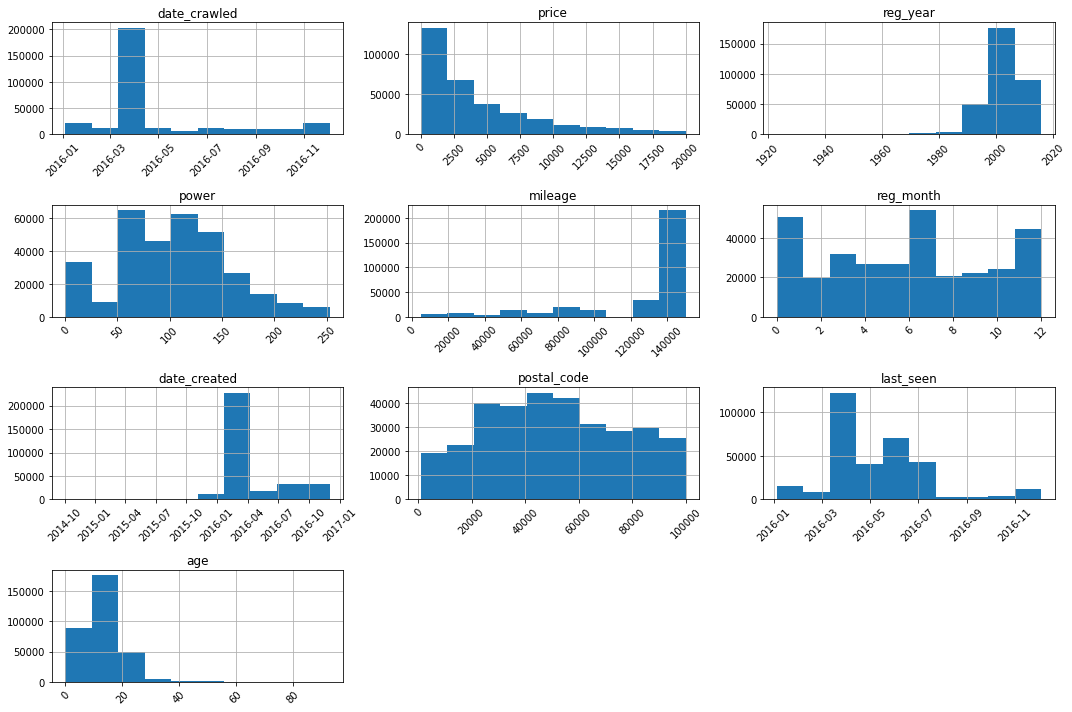

In [27]:
data.hist(figsize=(15, 10), xrot=45)
plt.tight_layout()
plt.show()

### Scatter matrix

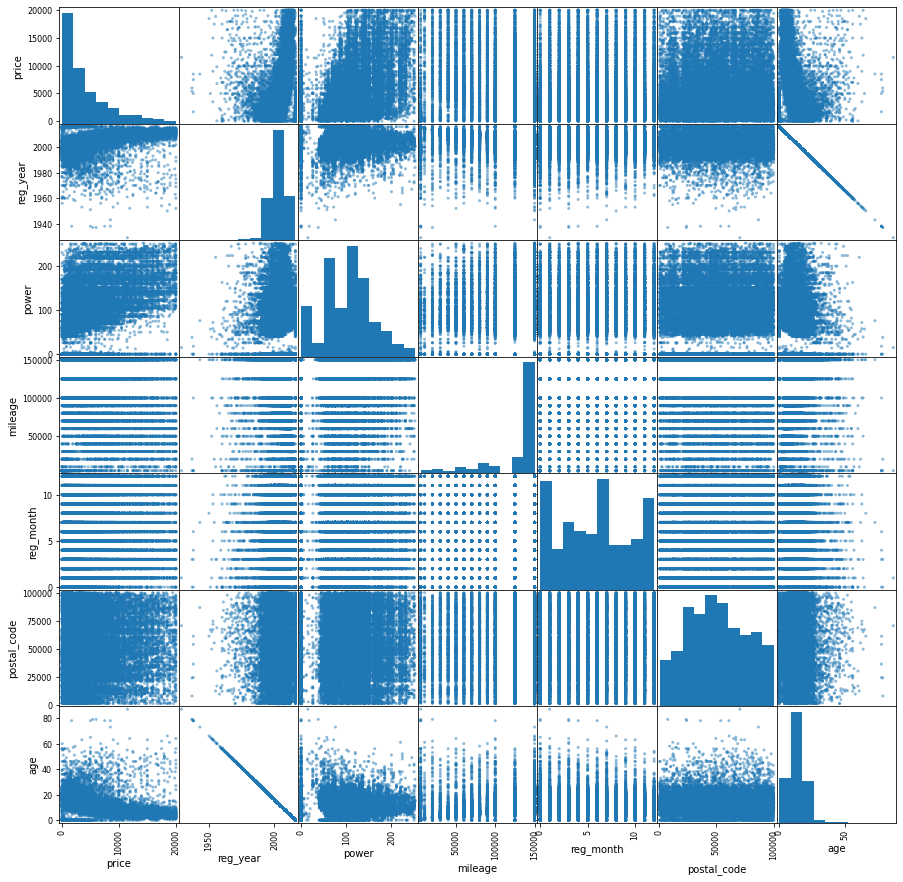

In [28]:
pd.plotting.scatter_matrix(data.sample(frac=0.1), figsize=(15, 15));

### Data correlation matrix

In [29]:
# Looking for multucollinearity 
data.corr().round(2).style.background_gradient()

## Categorical columns' diagrams

### Car brands

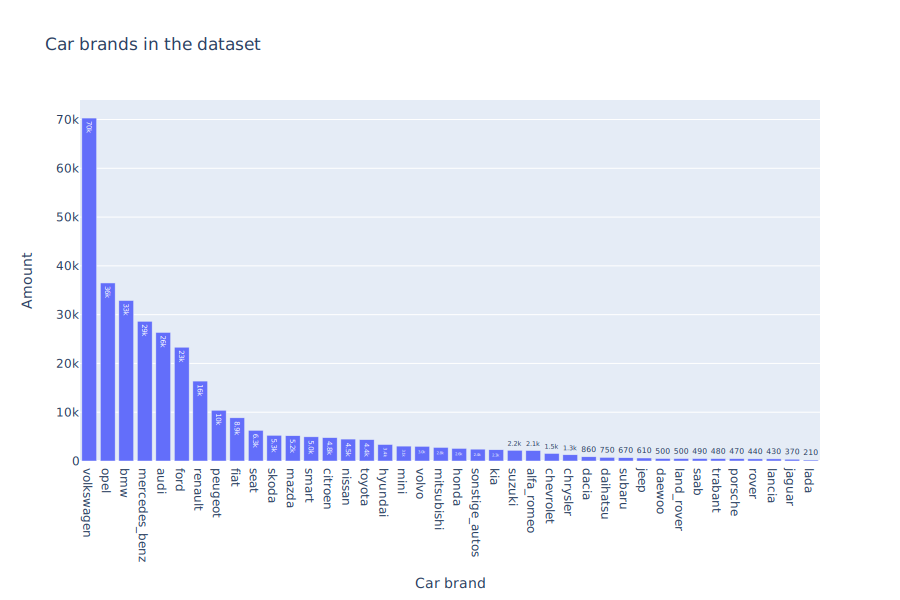

In [30]:
bar_data_1 = data.brand.value_counts(dropna=False).to_frame().sort_values(by='brand', ascending=False)
fig = px.bar(data_frame=bar_data_1, title='Car brands in the dataset',
             labels={'value':'Amount', 'index': 'Car brand'}, text_auto='0.2s')
fig.update_layout(showlegend=False) 
fig.show(renderer="svg", width = 900, height = 600)

### Car models

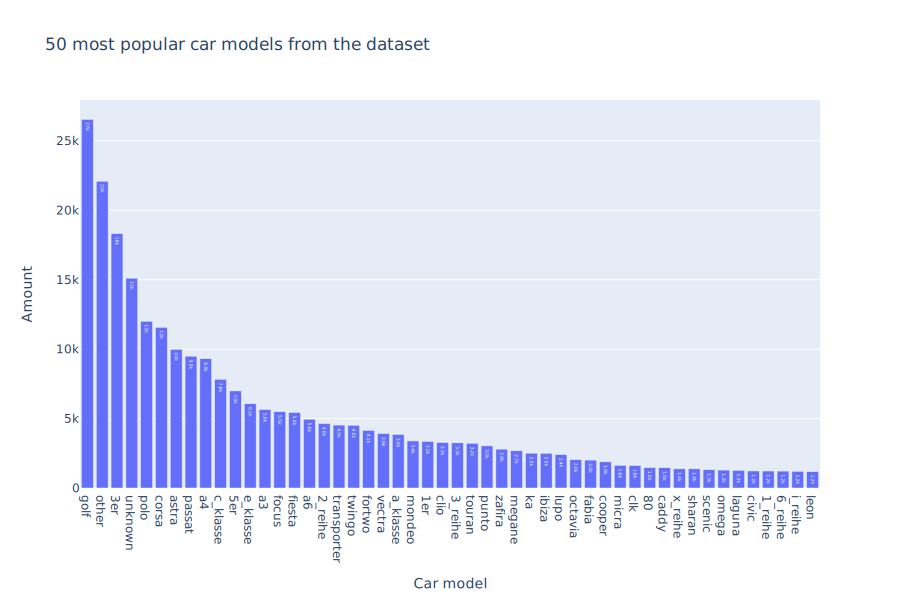

In [31]:
bar_data_2 = data.model.value_counts(dropna=False).to_frame().sort_values(by='model', ascending=False).head(50)
fig = px.bar(data_frame=bar_data_2, title='50 most popular car models from the dataset',
             labels={'value':'Amount', 'index': 'Car model'}, text_auto='0.2s')
fig.update_layout(showlegend=False) 
fig.show(renderer="svg", width = 900, height = 600)

### Vehicle type

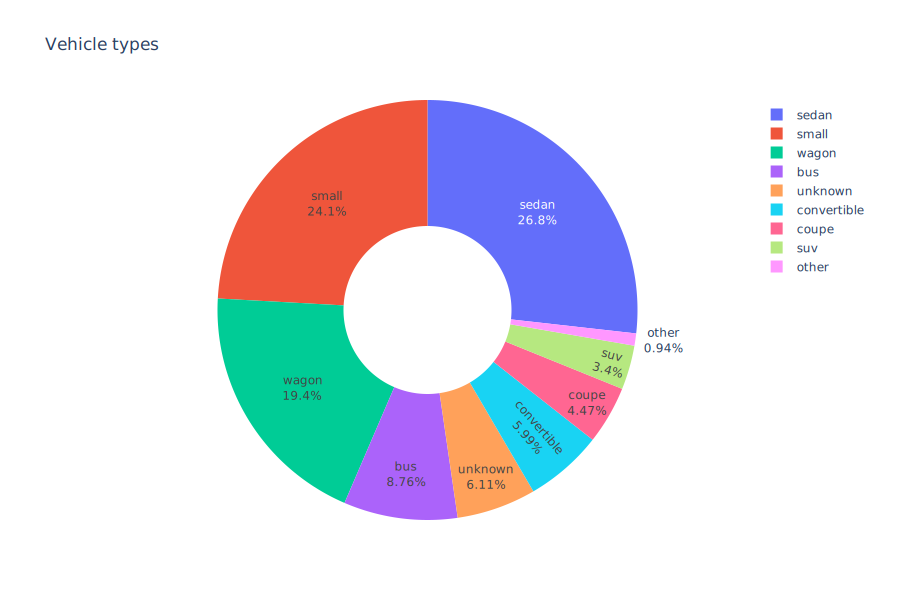

In [32]:
pie_data_3 = data.vehicle_type.value_counts(dropna=False).to_frame()
fig = px.pie(data_frame=pie_data_3, values='vehicle_type', title='Vehicle types', names=pie_data_3.index, hole=0.4)
fig.update_traces(text = pie_data_3.index)
fig.show(renderer="svg", width = 900, height = 600)

### Gear box and fuel type

In [33]:
pie_data_1 = data.gear_box.value_counts(dropna=False).to_frame()
pie_data_2 = data.fuel_type.value_counts(dropna=False).to_frame()
pie_data_4 = data.not_repaired.value_counts(dropna=False).to_frame()

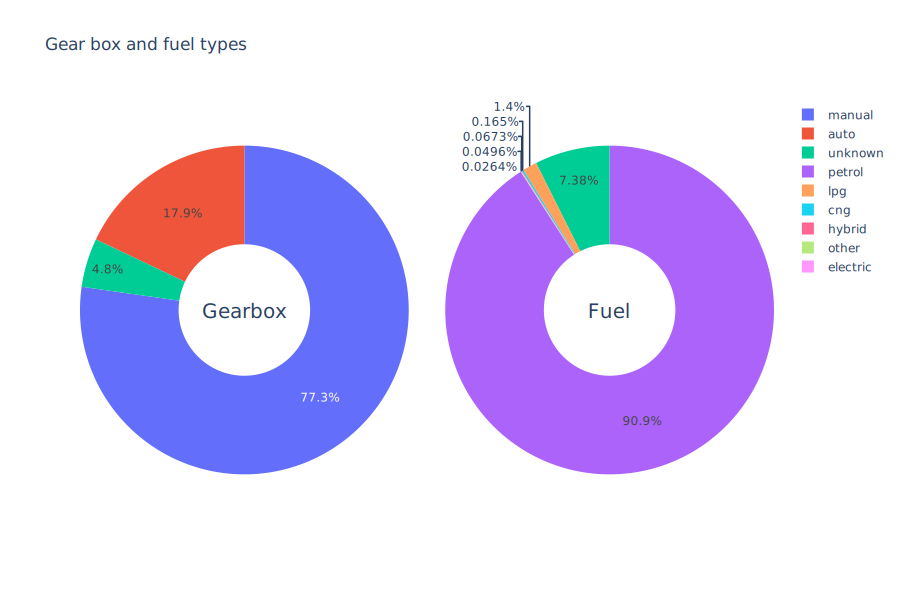

In [34]:
gear_box_types = pie_data_1.index.to_list()
gear_box_values = pie_data_1.gear_box.to_list()
fuel_types = pie_data_2.index.to_list()
fuel_values = pie_data_2.fuel_type.to_list()

import plotly.graph_objs as go
data1 = {
   "values": gear_box_values,
   "labels": gear_box_types,
   "domain": {"column": 0},
   "name": "Gear box",
   "hoverinfo":"label+percent+name",
   "hole": .4,
   "type": "pie"
}
data2 = {
   "values": fuel_values,
   "labels": fuel_types,
   "domain": {"column": 1},
   "name": "Fuel",
   "hoverinfo":"label+percent+name",
   "hole": .4,
   "type": "pie"
}
pie_data = [data1, data2]
layout = go.Layout(
   {
      "title":"Gear box and fuel types",
      "grid": {"rows": 1, "columns": 2},
      "annotations": [
         {
            "font": {
               "size": 20
            },
            "showarrow": False,
            "text": "Gearbox",
            "x": 0.175,
            "y": 0.5
         },
         {
            "font": {
               "size": 20
            },
            "showarrow": False,
            "text": "Fuel",
            "x": 0.795,
            "y": 0.5
         }
      ]
   }
)
fig = go.Figure(data = pie_data, layout = layout)
fig.update_traces()
#fig.update_layout(showlegend=False)
fig.show(renderer="svg", width = 900, height = 600)

### Vehicle repaired or not

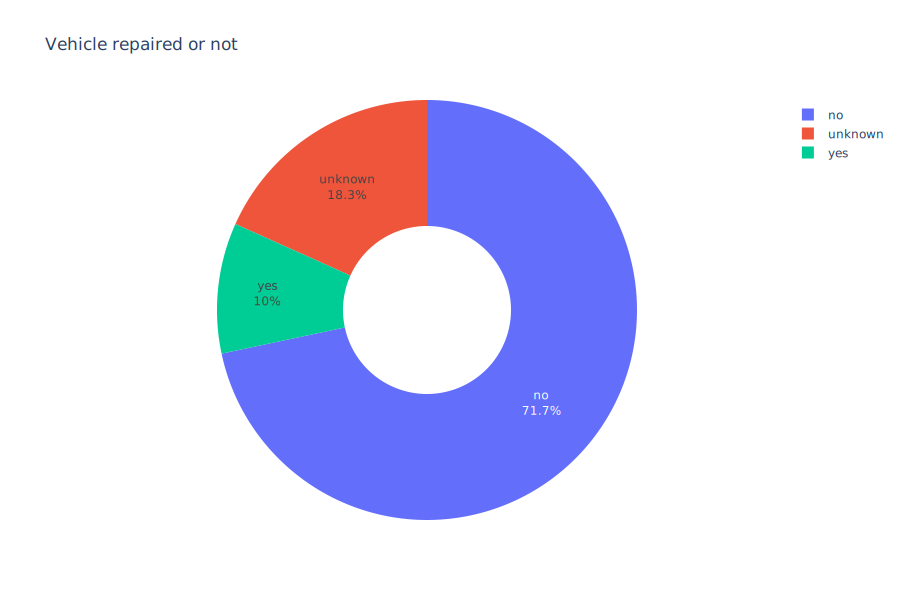

In [35]:
fig = px.pie(data_frame=pie_data_4, values='not_repaired', title='Vehicle repaired or not', names=pie_data_4.index, hole=0.4)
fig.update_traces(text = pie_data_4.index)
fig.show(renderer="svg", width = 900, height = 600)

## EDA conclusion

**1. Median values:**

We can observe such **median values** from the cleaned dataset : 
- `age`: 13 years
- `registration year`: 2003
- `price`: 2,800$
- `power`: 105 hp
- `mileage`: 150,000 km (market in km due to regional specifics)

These values gives us valuable info about vehicles presented in the dataset.

**2. Data correlation:**

<ins>Positive correlation coefficients</ins>:
- `price-power`: 0.46
- `price-reg_year`: 0.45
- `age-mileage`: 0.23

<ins>Negative correlation</ins>:
- `price-age`: -0.45
- `price-mileage`: -0.37

These positive and negative correlations look logical.

**3. Categorical columns:**

- Top-5 car brands are presented by European manufacturers, namely: VW, Opel, BMW, Mercedes Benz, and Audi.
- The most popular car model is VW Golf
- Top-3 most popular vehicle types are: sedan, small, and wagon.
- 75% of the market share takes manual gearbox and auto gear box takes only 18.7% (others are not specified).
- Petrol covers ~91% of the market share as a fuel type.
- Most of the cars (~72%) need some repairment.

# Model Training

## Data preparation

### Divide the data

In [36]:
# categorical columns which need OHE (one-hot-encoding)
cat_columns = ['vehicle_type', 'gear_box', 'model', 'fuel_type', 'brand', 'not_repaired']

# numerical columns (drop the `price` column coz it will go to the target-data)
num_columns = ['power', 'mileage', 'age']

# important columns for classification
imp_columns = ['price', 'vehicle_type', 'gear_box', 'power', 'model', 'mileage', 'fuel_type',
               'brand', 'not_repaired', 'age']

# remove unimportant columns from the dataset
data = data[imp_columns]

data.shape

(322495, 10)

### One-Hot-Encoding

In [37]:
data_ohe = pd.get_dummies(data, drop_first=True)
display(data_ohe.shape)

# Split the data
X = data_ohe.drop('price', axis=1)
y = data_ohe.price

X_train_ohe, X_test_ohe, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

(322495, 310)

### Ordinal Encoding

We will use OrindalEncoding class of sklearn for encoding categorical columns, it works better than OHE for tree-based algorithms. Data prepared in this step will be used for RandomForest, LightGBM and XGBoost. For Catboost we will prepare separate data, because it can handle categorical data.

In [38]:
data_oe = data.copy()

#construct the encoder
encoder = OrdinalEncoder()

#encode categorical columns and change the values in the dataframe
encoded = encoder.fit_transform(data_oe[cat_columns])
data_oe[cat_columns] = encoded

# Split the data
X = data_oe.drop('price', axis=1)
y = data_oe.price

X_train_oe, X_test_oe, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

data_oe.head()

price  vehicle_type  gear_box  power  model  mileage  fuel_type  brand  \
0    480           7.0       1.0      0  116.0   150000        5.0   38.0   
1  18300           2.0       1.0    190  227.0   125000        5.0    1.0   
2   9800           6.0       0.0    163  117.0   125000        5.0   14.0   
3   1500           5.0       1.0     75  116.0   150000        5.0   38.0   
4   3600           5.0       1.0     69  101.0    90000        5.0   31.0   

   not_repaired  age  
0           1.0   23  
1           2.0    5  
2           1.0   12  
3           0.0   15  
4           0.0    8

### Data scaling for linear regression

In [39]:
scaler = StandardScaler()

X_train_ohe[num_columns] = scaler.fit_transform(X_train_ohe[num_columns])
X_test_ohe[num_columns] = scaler.fit_transform(X_test_ohe[num_columns])

# X_train_oe[num_columns] = scaler.fit_transform(X_train_oe[num_columns])
# X_test_oe[num_columns] = scaler.fit_transform(X_test_oe[num_columns])

## Linear Regression

In [40]:
%%time
model = LinearRegression()
model.fit(X_train_ohe, y_train)

Wall time: 3.28 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [41]:
%%time
result = mean_squared_error(y_test, model.predict(X_test_ohe))
print(f'The RMSE score of the linear regression model is: {round(result**0.5)}')

The RMSE score of the linear regression model is: 2710.0
Wall time: 147 ms


## Decision Tree

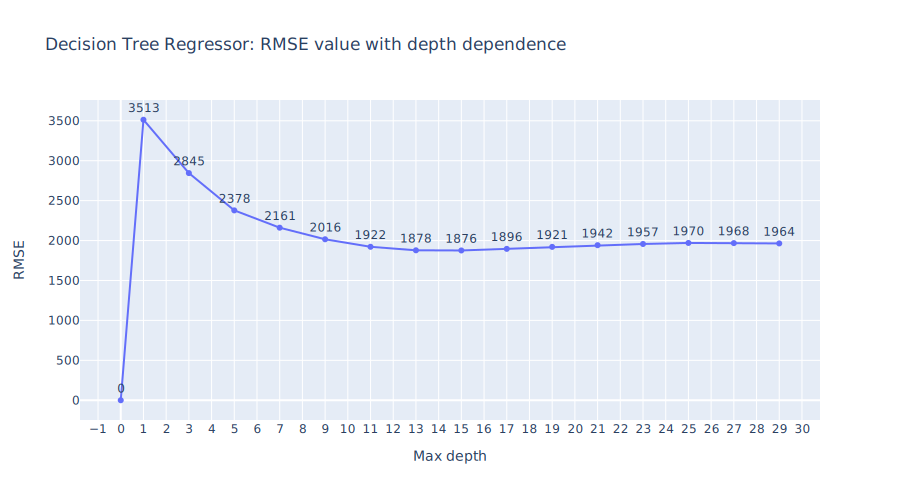

Wall time: 20.3 s


In [42]:
%%time

# create dataframe to write down the results
result_df = pd.DataFrame({'depth': [0], 'rmse': [0]})

best_model= None
best_result = 3000
best_depth = 0

for depth in range(1, 31, 2):
    model = DecisionTreeRegressor(random_state=42, max_depth=depth)
    mse = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
    rmse = np.sqrt(mse*-1)
    avg_rmse = np.sum(rmse)/len(rmse)
    result_df.loc[depth] = (depth, round(avg_rmse))
    #print(f'max_depth: {depth}; RMSE: {round(avg_rmse)}')
    if avg_rmse < best_result:
        best_model = model
        best_result = avg_rmse
        best_depth = depth
        
# Make a results graph
fig = px.line(result_df, x='depth', y='rmse', markers=True,
              title='Decision Tree Regressor: RMSE value with depth dependence', text='rmse')
fig.update_layout(xaxis_title="Max depth", yaxis_title="RMSE", xaxis = dict(dtick = 1))
fig.update_traces(textposition='top center')
fig.show(renderer="svg", width = 900, height = 500)

> We can make a graph out of the achieved results since we have only 2 features: `max_depth` and `RMSE`. As we can see, the `RMSE` value decreases with `max_depth` increase and reaches its **minimum at `max_depth` = 15**. Later, we can see over-fitting, where increase in `max_depth` increases the `RMSE` values.

In [43]:
%%time

# fit the best model
best_model.fit(X_train_oe, y_train)

Wall time: 724 ms


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=15,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [44]:
%%time

# prediction with the best model
mse = mean_squared_error(y_test, best_model.predict(X_test_oe))
rmse = np.sqrt(mse)
print("RMSE of the best DecisionTreeRegressor model:", round(rmse))
print(f"Best hyperparameters: \nmax_depth:", best_depth)

RMSE of the best DecisionTreeRegressor model: 1884.0
Best hyperparameters: 
max_depth: 15
Wall time: 25 ms


## Random Forest Regressor

In [45]:
%%time

best_model= None
best_result = 3000
best_depth = 0
best_est = 0

for est in range(30, 51, 10):
    print('n_estimators: ', est)
    for depth in range(10, 21, 5):
        model = RandomForestRegressor(random_state=42, max_depth=depth, n_estimators = est, n_jobs=-1)
        mse = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
        rmse = np.sqrt(mse*-1)
        avg_rmse = np.sum(rmse)/len(rmse)
        print("max_depth:", depth, "; RMSE:", round(avg_rmse))
        if avg_rmse < best_result:
            best_model = model
            best_result = avg_rmse
            best_depth = depth
            best_est = est
    print('=' * 35)

n_estimators:  30
max_depth: 10 ; RMSE: 1863.0
max_depth: 15 ; RMSE: 1638.0
max_depth: 20 ; RMSE: 1600.0
n_estimators:  40
max_depth: 10 ; RMSE: 1862.0
max_depth: 15 ; RMSE: 1635.0
max_depth: 20 ; RMSE: 1596.0
n_estimators:  50
max_depth: 10 ; RMSE: 1861.0
max_depth: 15 ; RMSE: 1633.0
max_depth: 20 ; RMSE: 1593.0
Wall time: 2min 32s


In [46]:
%%time

# fit the best model
best_model.fit(X_train_oe, y_train)

Wall time: 8.02 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [47]:
%%time

# prediction with the best model
mse = mean_squared_error(y_test, best_model.predict(X_test_oe))
rmse = np.sqrt(mse)
print("RMSE of the best RandomForestRegressor model:", round(rmse))
print(f"Best hyperparameters: \nn_estimators:",
      best_est, "; max_depth:", best_depth)

RMSE of the best RandomForestRegressor model: 1598.0
Best hyperparameters: 
n_estimators: 50 ; max_depth: 20
Wall time: 565 ms


## LightGBMRegressor

In [48]:
%%time

final_model = None
best_model= None
best_result = 3000
best_depth = 0
best_est = 0
best_learning_rate = 0

# Settings:
learning_range = [0.2, 0.3]
est_range = range(100, 161, 30)
leaves_range = range(70, 131, 30)

for rate in learning_range:
    print('learning_rate: ', rate)
    print('')
    for est in est_range:
        print('n_estimators: ', est)
        for leaves in leaves_range:
            model = LGBMRegressor(learning_rate=rate, num_leaves=leaves, n_estimators=est, n_jobs=-1,
                                  random_state=42, silent=True)
            mse = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
            rmse = np.sqrt(mse*-1)
            avg_rmse = np.sum(rmse)/len(rmse)
            print("num_leaves:", leaves, "; RMSE:", round(avg_rmse))
            if avg_rmse < best_result:
                best_model = model
                best_result = avg_rmse
                best_leaves = leaves
                best_est = est
                best_learning_rate = rate
        print('=' * 35)

learning_rate:  0.2

n_estimators:  100
num_leaves: 70 ; RMSE: 1582.0
num_leaves: 100 ; RMSE: 1566.0
num_leaves: 130 ; RMSE: 1555.0
n_estimators:  130
num_leaves: 70 ; RMSE: 1570.0
num_leaves: 100 ; RMSE: 1555.0
num_leaves: 130 ; RMSE: 1546.0
n_estimators:  160
num_leaves: 70 ; RMSE: 1560.0
num_leaves: 100 ; RMSE: 1548.0
num_leaves: 130 ; RMSE: 1541.0
learning_rate:  0.3

n_estimators:  100
num_leaves: 70 ; RMSE: 1574.0
num_leaves: 100 ; RMSE: 1561.0
num_leaves: 130 ; RMSE: 1557.0
n_estimators:  130
num_leaves: 70 ; RMSE: 1563.0
num_leaves: 100 ; RMSE: 1552.0
num_leaves: 130 ; RMSE: 1551.0
n_estimators:  160
num_leaves: 70 ; RMSE: 1554.0
num_leaves: 100 ; RMSE: 1546.0
num_leaves: 130 ; RMSE: 1547.0
Wall time: 1min 12s


In [49]:
%%time

# fit the best model
best_model.fit(X_train_oe, y_train)
final_model = best_model

Wall time: 1.41 s


In [50]:
%%time

# prediction with the best model
mse = mean_squared_error(y_test, best_model.predict(X_test_oe))
rmse = np.sqrt(mse)
print("LightGBMRegressor best model RMSE:", round(rmse))
print(f"Best hyperparameters: \nlearning_rate: {best_learning_rate}; n_estimators: {best_est}; num_leaves: {best_leaves}")

LightGBMRegressor best model RMSE: 1551.0
Best hyperparameters: 
learning_rate: 0.2; n_estimators: 160; num_leaves: 130
Wall time: 264 ms


## XGBoostRegressor

In [51]:
%%time

best_model= None
best_result = 3000
best_depth = 0
best_est = 0
best_learning_rate = 0

# Settings:
learning_range = [0.1, 0.3, 0.5]
depth_range = range(5, 16, 5)

for rate in learning_range:
    print(f'learning_rate: {rate}')
    for depth in depth_range:
        model = xgb.XGBRegressor(learning_rate=rate, max_depth=depth, n_jobs=-1, random_state=42)
        mse = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
        rmse = np.sqrt(mse*-1)
        avg_rmse = np.sum(rmse)/len(rmse)
        print("max_depth:", depth, "; RMSE:", round(avg_rmse))
        if avg_rmse < best_result:
            best_model = model
            best_result = avg_rmse
            best_depth = depth
            best_learning_rate = rate
    print("=" * 35)

learning_rate: 0.1
max_depth: 5 ; RMSE: 1722.0
max_depth: 10 ; RMSE: 1546.0
max_depth: 15 ; RMSE: 1574.0
learning_rate: 0.3
max_depth: 5 ; RMSE: 1649.0
max_depth: 10 ; RMSE: 1547.0
max_depth: 15 ; RMSE: 1625.0
learning_rate: 0.5
max_depth: 5 ; RMSE: 1636.0
max_depth: 10 ; RMSE: 1596.0
max_depth: 15 ; RMSE: 1682.0
Wall time: 6min 39s


In [52]:
%%time

# fit the best model
best_model.fit(X_train_oe, y_train)

Wall time: 10.9 s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=42, reg_alpha=0, ...)

In [53]:
%%time

# prediction with the best model
mse = mean_squared_error(y_test, best_model.predict(X_test_oe))
rmse = np.sqrt(mse)
print("XGBoostRegressor best model RMSE:", round(rmse))
print(f"Best hyperparameters: \nlearning_rate: {best_learning_rate}; max_depth: {best_depth}")

XGBoostRegressor best model RMSE: 1558.0
Best hyperparameters: 
learning_rate: 0.1; max_depth: 10
Wall time: 152 ms


## CatBoostRegressor

In [54]:
# get target and feature columns from df without encoding
X = data.drop('price', axis=1)
y = data['price']

scaler = StandardScaler()

X[num_columns] = scaler.fit_transform(X[num_columns])

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
X_test[num_columns] = scaler.fit_transform(X_test[num_columns])

In [55]:
%%time

best_model= None
best_result = 3000
best_depth = 0
best_iterations = 0
best_learning_rate = 0

# Settings:
learning_range = [0.3, 0.5]
depth_range = range(10, 16, 5)
iterations_range = range(15, 26, 5)

for rate in learning_range:
    print(f'learning_rate: {rate}')
    for depth in depth_range:
        print(f'depth: {depth}')
        for iterations in iterations_range:
            model=CatBoostRegressor(iterations=iterations, learning_rate=rate, depth=depth,
                                    random_state=42, cat_features=cat_columns, silent=True)
            mse = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
            rmse = np.sqrt(mse*-1)
            avg_rmse = np.sum(rmse)/len(rmse)
            print("iterations:", iterations, "; RMSE:", round(avg_rmse))
            if avg_rmse < best_result:
                best_model = model
                best_result = avg_rmse
                best_depth = depth
                best_learning_rate = rate
                best_iterations = iterations
    print("=" * 35)

learning_rate: 0.3
depth: 10
iterations: 15 ; RMSE: 1755.0
iterations: 20 ; RMSE: 1721.0
iterations: 25 ; RMSE: 1701.0
depth: 15
iterations: 15 ; RMSE: 1678.0
iterations: 20 ; RMSE: 1653.0
iterations: 25 ; RMSE: 1634.0
learning_rate: 0.5
depth: 10
iterations: 15 ; RMSE: 1724.0
iterations: 20 ; RMSE: 1695.0
iterations: 25 ; RMSE: 1675.0
depth: 15
iterations: 15 ; RMSE: 1652.0
iterations: 20 ; RMSE: 1634.0
iterations: 25 ; RMSE: 1618.0
Wall time: 3min 42s


In [56]:
%%time

# fit the best model
best_model.fit(X_train, y_train)

Wall time: 20.7 s


In [57]:
%%time

# prediction with the best model
mse = mean_squared_error(y_test, best_model.predict(X_test))
rmse = np.sqrt(mse)
print("CatBoostRegressor best model RMSE:", round(rmse))
print(f"Best hyperparameters: \nlearning_rate: {best_learning_rate}; max_depth: {best_depth}; iterations: {best_iterations}")

CatBoostRegressor best model RMSE: 1648.0
Best hyperparameters: 
learning_rate: 0.5; max_depth: 15; iterations: 25
Wall time: 227 ms


## Performance comparison

In [58]:
# Create a DataFrame with results

model_names = ['Linear Reg', 'Decision Tree', 'Random Forest', 'LightGBM',
               'XGBoost', 'CatBoost']
rmse_values = [2710, 1881, 1597, 1551, 1558, 1648]
fitting_time = [3.55, 0.708, 8.32, 1.27, 8.16, 22.1]
prediction_time = [137, 25, 596, 261, 144, 227]

result_df = pd.DataFrame(data=zip(model_names, rmse_values, fitting_time, prediction_time),
                         columns=['model', 'rmse', 'fitting time [s]', 'prediction time [ms]'])

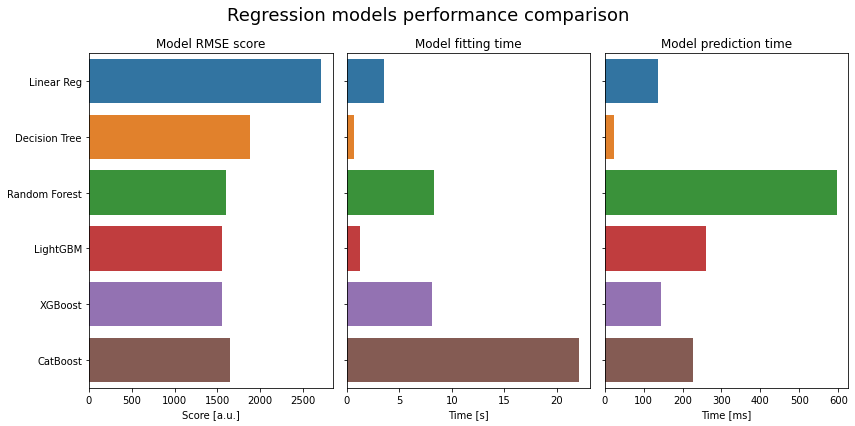

In [59]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

sns.barplot(x=result_df.rmse, y=result_df.model, ax=ax[0])
ax[0].set(xlabel='Score [a.u.]', ylabel='', title='Model RMSE score')

sns.barplot(x=result_df['fitting time [s]'], y=result_df.model, ax=ax[1])
ax[1].set(yticklabels=[], title='Model fitting time', xlabel='Time [s]', ylabel='')

sns.barplot(x=result_df['prediction time [ms]'], y=result_df.model, ax=ax[2])
ax[2].set(yticklabels=[], title='Model prediction time', xlabel='Time [ms]', ylabel='')

fig.suptitle('Regression models performance comparison', fontsize=18)
plt.tight_layout()
plt.show()

## Feature importances of the best model

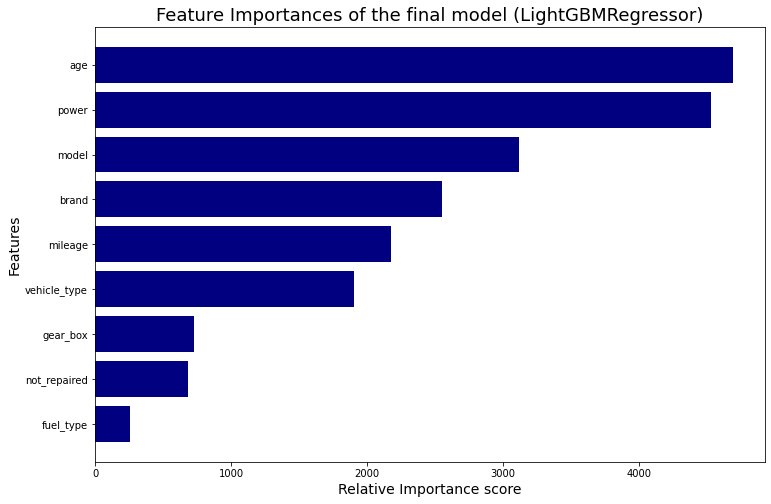

In [60]:
#plot a curve showing the relative importance of each feature on the model
features=X.columns.tolist()
importances=final_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,8))
plt.title('Feature Importances of the final model (LightGBMRegressor)', fontsize=18)
plt.barh(range(len(indices)), importances[indices], color='navy', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance score', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.show()

## Model training conclusion

In this section, we have trained and tested the following algorithms:


|Algorithm            |Encoding              |Scaling        |Tuned Hyperparamteres                  |
|---------------------|----------------------|---------------|---------------------------------------|
|Linear Regression    |One hot encoding      |StandardScaler |None                                   |
|Decision Tree        |Label encoding        |None |max_depth                              |
|Random Forest        |Label encoding        |None |n_estimators, max_depth                |
|LightGBM             |Label encoding        |None |learning_rate, num_leaves, n_estimators|
|XGBoost              |Label encoding        |None |learning_rate, max_depth               |
|CatBoost             |built-in encoder      |None |iterations, learning_rate, depth       |
    
Best achieved results:    
    
|Algorithm	      |RMSE	|Fitting Time [s]|	Prediction Time [ms] |
|-----------------|-----|----------------|-----------------------|
|Linear Regression|2710 |	3.550	     |137                    |
|Decision Tree    |1881 |	0.708	     |25                     |
|Random Forest    |1597 |	8.320	     |596                    |
|LightGBM         |1551 |	1.270	     |261                    |
|XGBoost	      |1558 |	8.160	     |144                    |
|CatBoost	      |1648 |	22.100	     |227                    |
    
Linear Regression model has served here as a basic model for a sanity check and for comparison with the others.

We can see, that the `Linear Regression` had the worst performance of all the tested models with RMSE = $\pm$2710 €.
`DecisionTree` has also not shown good results with RMSE = $\pm$1881 €. Worth noting that the `DecisionTree` has the fastest fitting time, and prediction time of 0.89 seconds and 32 ms, respectibely.
Both the `CatBoost`, and the `Random Forest` have shown pretty comparable decent results with RMSE = $\pm$1648 €, and RMSE = $\pm$1597 €, respectively. Finally, the lowest RSME value have shown the `XGBoost` and the `LightGBM`: RMSE = $\pm$1558 €, and RMSE = $\pm$1551 €, respectively. 

**This being said, the `LightGBM` model is a clear winner for predicting car prices. It combines the best RMSE value, together with rapid fitting and prediction time.**

# Summary

In this project we have done such things:
- Data Upload and general overview.
- Data preparation (column rename, values correction, creation of new columns, etc.), and cleaning since the dataset had a lot of issues (duplicates, wrong values, missing value, etc.).
- EDA, made after the initial data preparation have shown good results in the coefficient correlation matrix, showing us some dependencies between parameters (e.g. price-age, and price-power). Later, during the model training, we will confirm that these dependencies are really important. Furthermore we have found out the most popular car brands, models, body types, gear boxes, and fuel types. Interestingly, most of the cars should have some repairment.
- Finally, we have encoded the data and a bunch of ML models have been tested to predict car prices. Among all, the **LightGBMRegressor** has shown the best RMSE value ($\pm$1551 €), together with rapid fitting and prediction time. The most important parameters for this model to predict the car `price` were `age` and `power`, since we had good positive correlation coefficients between them in the correlation matrix.
